# Path setup & import packages

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from core.ws_regression import *
from datasets.imdb_tmdb_dataset import * 
from datasets.basic_clmn_dataset import * 
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.stats as ss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
seed = 42
feature_drop_cols = ['vote_average', 'imdbId', 'movieId','tmdbId']
label_feature = 'vote_average'

# Fully supervised

In [2]:
# read data
df = pd.read_csv(os.path.join(root_path, 'data',
                              'imdb-tmdb', 'merged_imdb_tmdb_with_additional_features.csv')).fillna(0)

X, Y = df.drop(feature_drop_cols, axis=1), df[label_feature]

# split data
train_fraction = 0.75
# # split data
indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
X_train = X.iloc[indices_train]
Y_train = Y[indices_train]
X_test = X.iloc[indices_test]
Y_test = Y[indices_test]

# model declaration and fit
model = Pipeline([
    ("std", StandardScaler()),
    ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
])
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
true_mse = mean_squared_error(Y_test, Y_test_pred)
print('MSE', true_mse)

MSE 0.37324481674300336


# Look into features

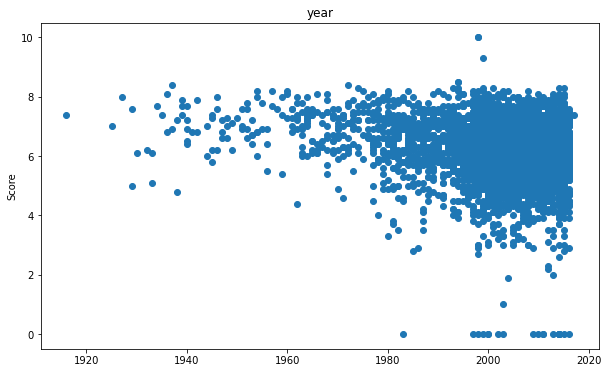

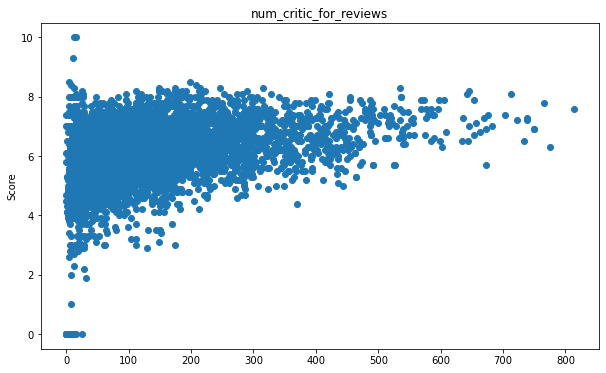

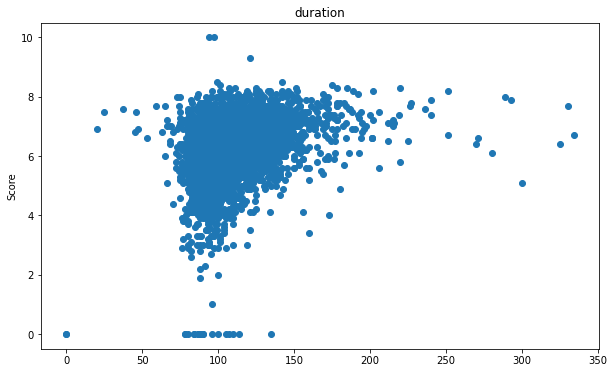

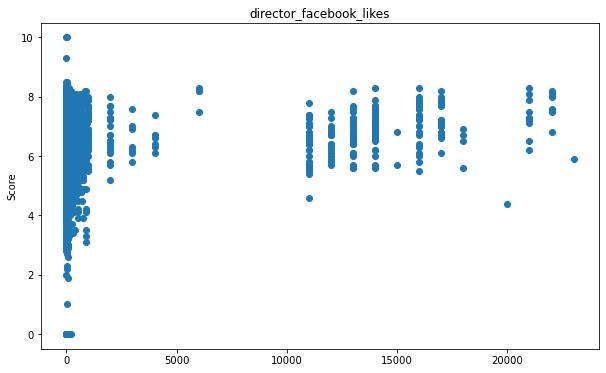

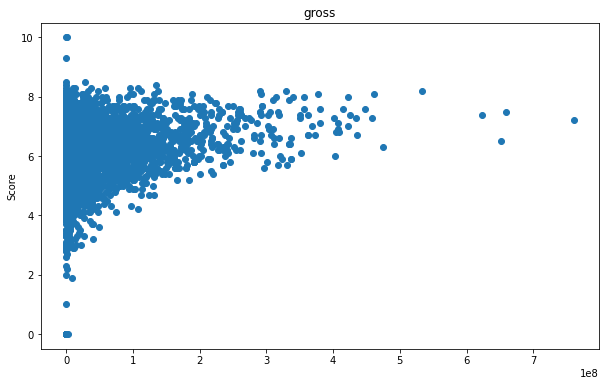

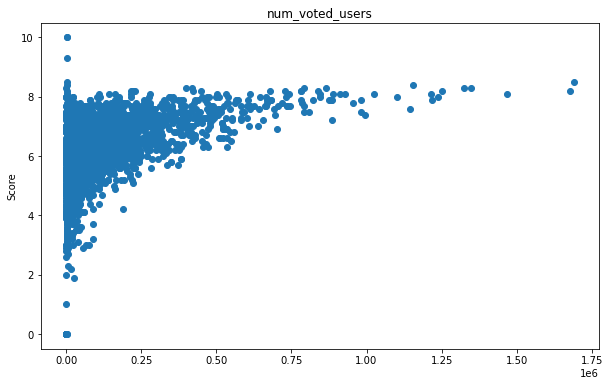

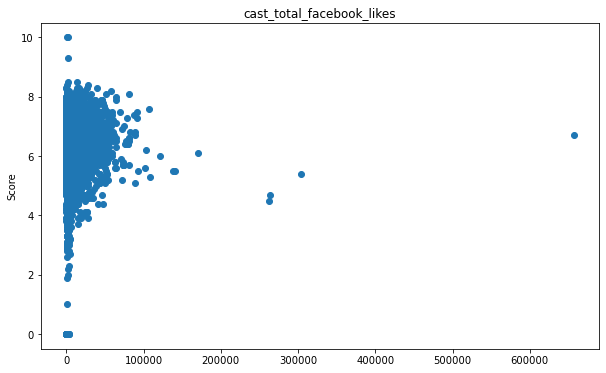

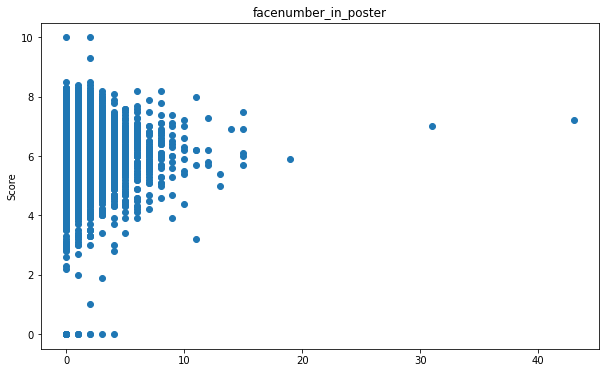

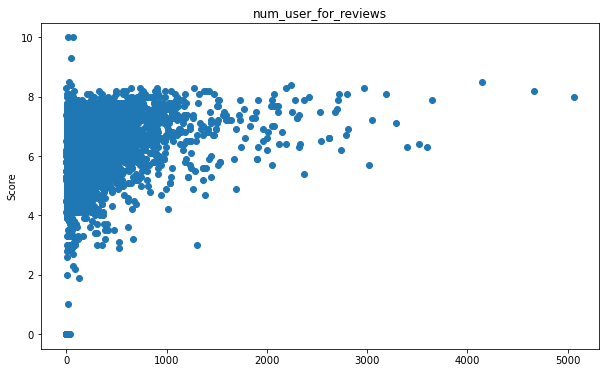

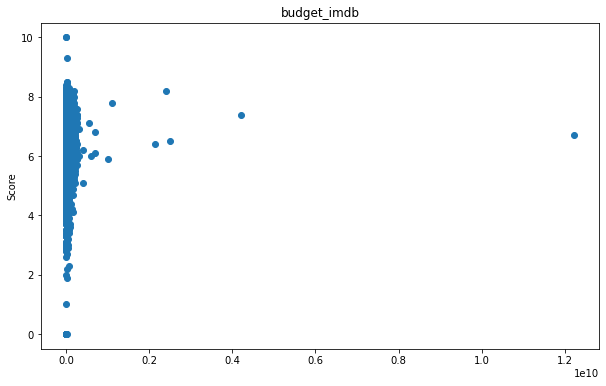

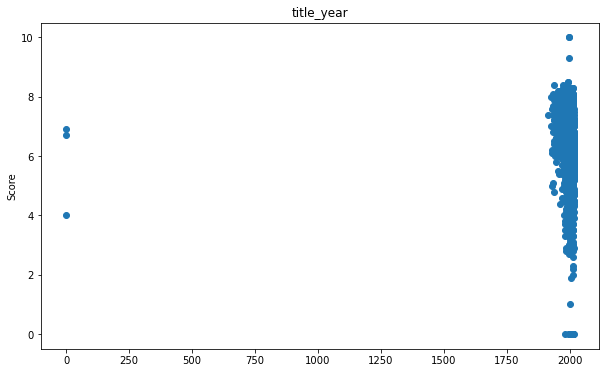

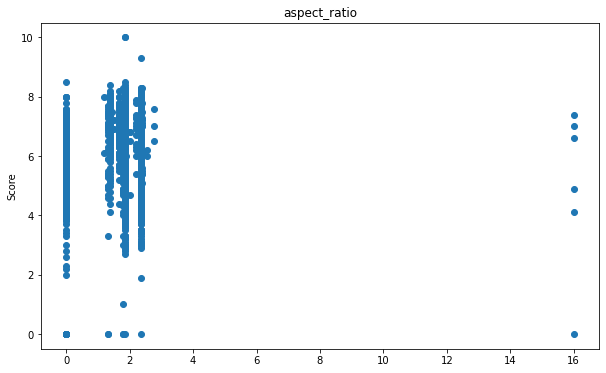

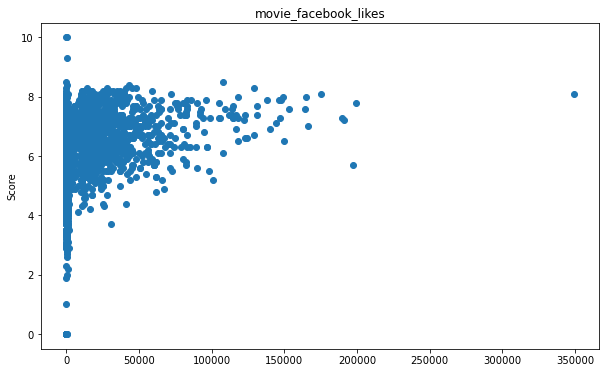

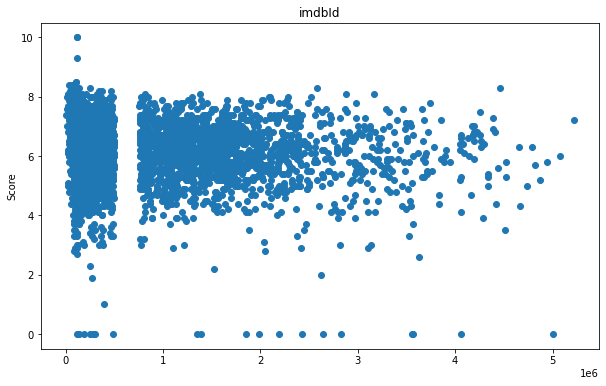

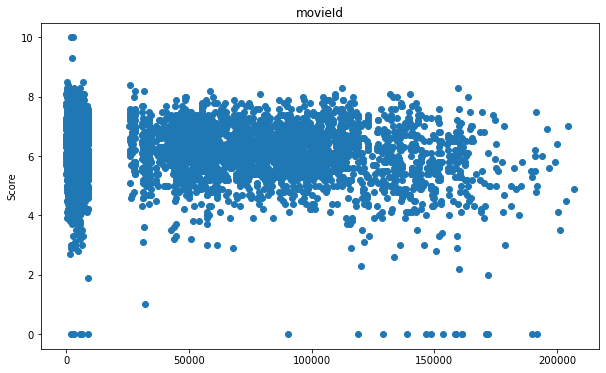

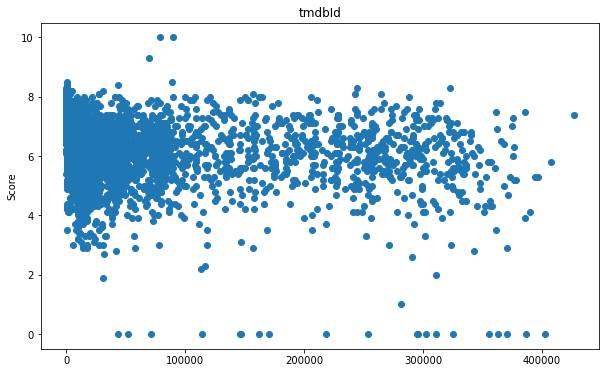

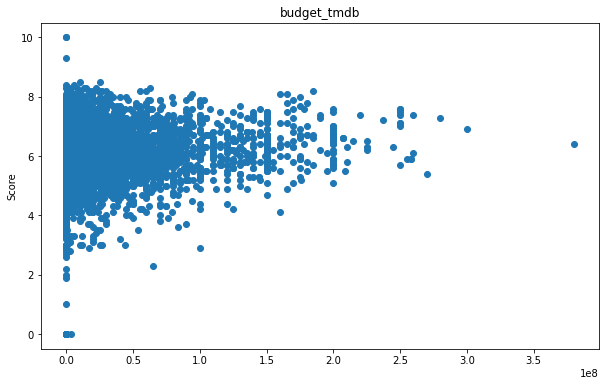

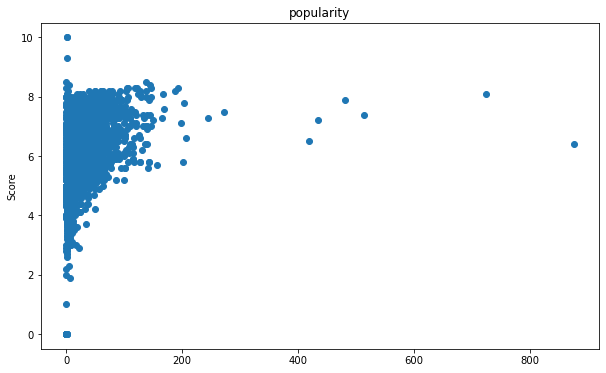

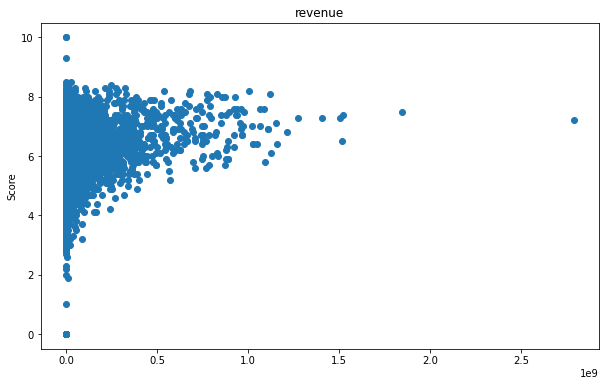

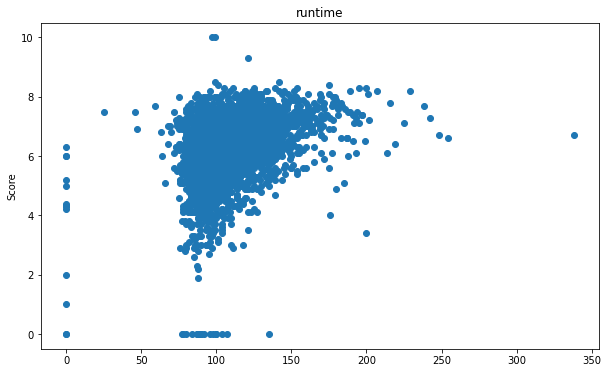

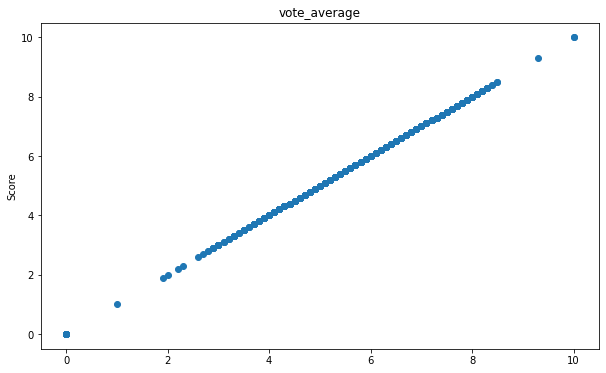

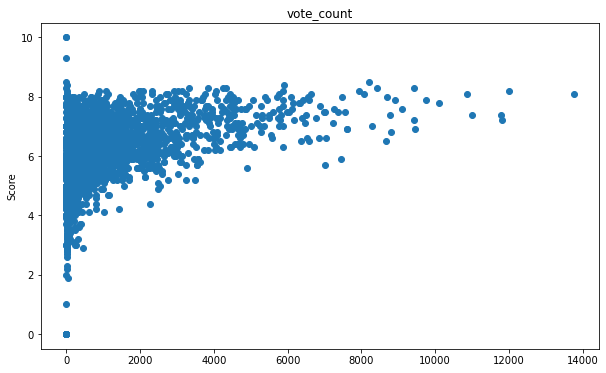

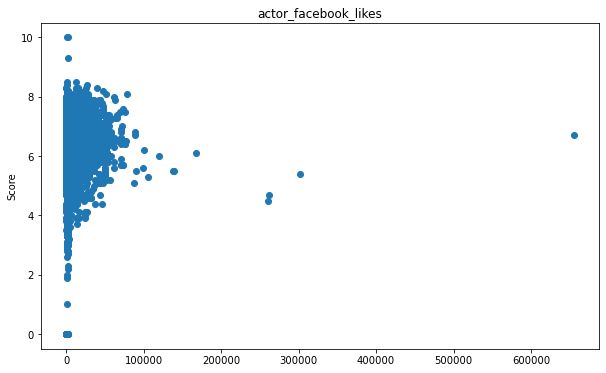

In [3]:
continuous_feature_list = []
for col in df.columns:
    if len(df[col].unique()) > 10:
        continuous_feature_list.append(col)
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.scatter(df[col], Y, label='gt')
        plt.ylabel('Score')
        plt.title(col)
        plt.show()

# Weak Supervision

In [4]:
def make_scaling_features(df, wl_features):
    weak_labels = []
    for col in wl_features:
        scaler = MinMaxScaler()
        val = scaler.fit_transform(df[col].values.reshape(-1, 1)) * 10
        weak_labels.append(val)
    
    return np.hstack(weak_labels)

In [9]:
continuous_feature_list

['year',
 'num_critic_for_reviews',
 'duration',
 'director_facebook_likes',
 'gross',
 'num_voted_users',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'num_user_for_reviews',
 'budget_imdb',
 'title_year',
 'aspect_ratio',
 'movie_facebook_likes',
 'imdbId',
 'movieId',
 'tmdbId',
 'budget_tmdb',
 'popularity',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count',
 'actor_facebook_likes']

In [16]:
wl_features = [
 'num_critic_for_reviews',
 'budget_tmdb',
 'popularity',
 'revenue',
 'runtime']
len(wl_features)

5

In [17]:
n = len(Y)
L = make_scaling_features(df, wl_features)
L = L - L.mean(axis=0)


true_Sigma = np.cov(np.concatenate([L, Y.values.reshape(-1, 1)], axis=1).T)

param_err 0.0485672420172687 mu_err 0.24726401062104517 label model score 1.568555049997665


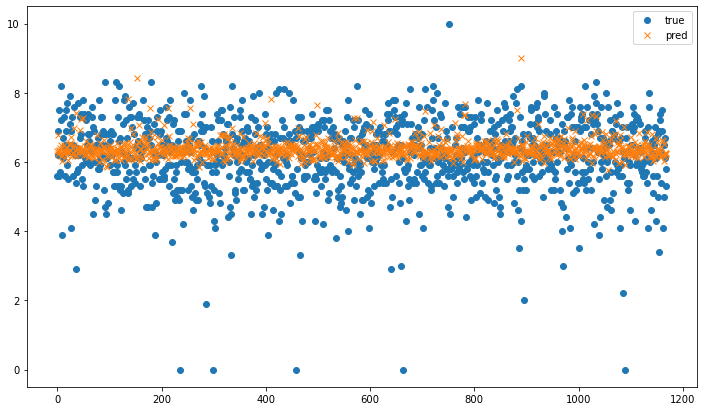

1.1114984246924497


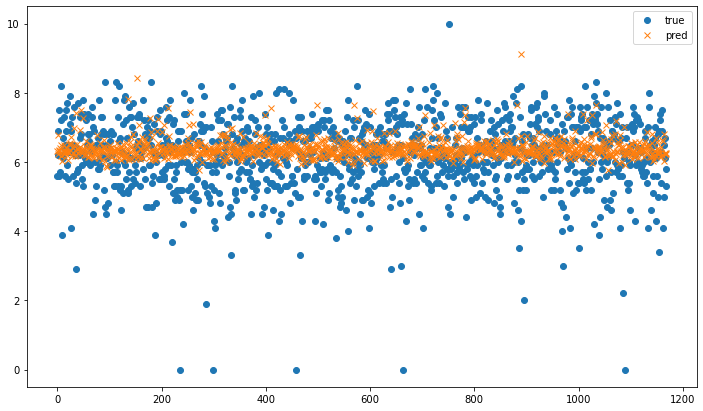

1.1151291711013236


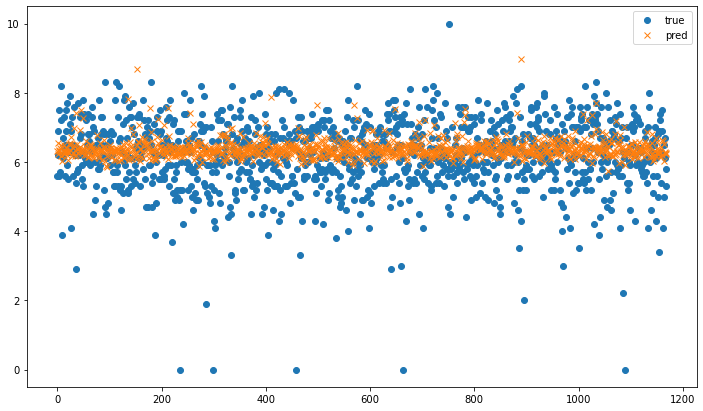

1.1140771309748896


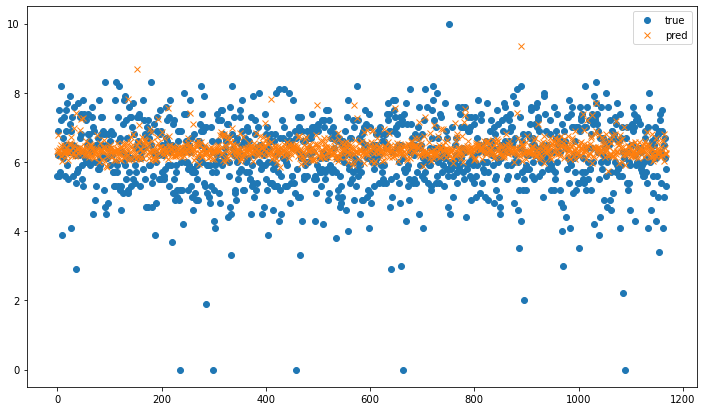

1.1151624522150212


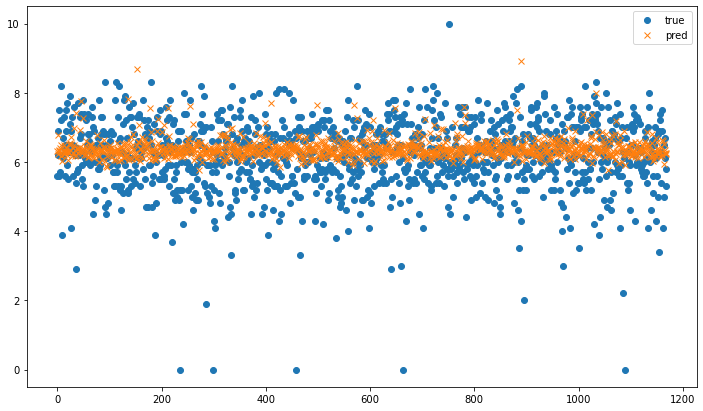

1.119293837354248


In [18]:
Y_mean = Y.mean()
Y_var = Y.var()

# Label model
lm = LabelModel()
lm.fit(L, Y_var)
lm.inference(L)
Y_hat = np.clip(lm.Y_hat + Y_mean, 0, 10)
Y_hat_train = Y_hat[:X_train.shape[0]]

# Label model performance check
m = L.shape[1]
Sigma_hat = lm.Sigma_hat
param_err = np.linalg.norm(Sigma_hat - true_Sigma) / (m+1)**2
mu_err    = np.linalg.norm(Sigma_hat[:m,m] - true_Sigma[:m,m]) / m
score = lm.score(Y - Y_mean)

print('param_err', param_err,
      'mu_err', mu_err,
      'label model score', score)

df_result = pd.DataFrame()
for seed in range(5):
    # End model declaration and fit
    model = Pipeline([
        ("std", StandardScaler()),
        ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
    ])
    model.fit(X_train, Y_hat_train)

    # result visualization
    fig, ax = plt.subplots(figsize=(12, 7 ))
    Y_test_pred = np.clip(model.predict(X_test), 0, 10)
    plt.plot(Y_test.values, 'o', label='true')
    plt.plot(Y_test_pred, 'x', label='pred')
    plt.legend()
    plt.show()
    plt.show()
    df_result = df_result.append({
        'cond': '.',
        'seed': seed,
        'score': score,
        'mse': mean_squared_error(Y_test, Y_test_pred)
    }, ignore_index=True)
    print(mean_squared_error(Y_test, Y_test_pred))

In [19]:
df_result.groupby(by='cond').agg(['mean', 'std'])

mse              score      seed          
          mean      std      mean  std mean       std
cond                                                 
.     1.115032  0.00281  1.568555  0.0  2.0  1.581139